<a href="https://colab.research.google.com/github/ergul13/mr_akgul/blob/main/NBCL_Binary_Egitim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom
import os
import shutil
import pandas as pd
import cv2
import numpy as np
import glob
import pydicom
from google.colab import drive, files

# Ayarlar
base_dir = '/content/tubitak_data'
meta_dir = f'{base_dir}/meta'
images_dir = f'{base_dir}/images'

# Klasörleri kontrol et, yoksa oluştur (Silme yapmiyoruz ki metadata gitmesin)
os.makedirs(meta_dir, exist_ok=True)
os.makedirs(images_dir, exist_ok=True)

print("----------------------------------------------------------------")
print("ADIM 0: KAGGLE API AYARLAMASI")
print("----------------------------------------------------------------")

# Kaggle API dosyasi kontrolü
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Kaggle API anahtari bulunamadi. Lutfen 'kaggle.json' dosyasini yukleyin.")
    uploaded = files.upload()

    for fn in uploaded.keys():
        if 'kaggle.json' in fn:
            os.system('mkdir -p ~/.kaggle')
            os.system(f'mv {fn} ~/.kaggle/')
            os.system('chmod 600 ~/.kaggle/kaggle.json')
            print("Kaggle API anahtari kuruldu.")
else:
    print("Kaggle API anahtari zaten mevcut.")

print("\n----------------------------------------------------------------")
print("ADIM 1: METADATA KONTROLU")
print("----------------------------------------------------------------")

# Onceki adimda yuklenen dosyalar duruyor mu?
rsna_csv_path = f'{meta_dir}/rsna_train.csv'
inbreast_xls_path = glob.glob(f'{meta_dir}/INbreast*')

if not os.path.exists(rsna_csv_path):
    print("UYARI: RSNA 'train.csv' dosyasi bulunamadi (silinmis olabilir).")
    print("Lutfen 'train.csv' dosyasini tekrar yukleyin.")
    uploaded = files.upload()
    for fn in uploaded.keys():
        shutil.move(fn, rsna_csv_path)

if not inbreast_xls_path:
    print("UYARI: INbreast excel dosyasi bulunamadi.")
    print("Lutfen 'INbreast.xls' dosyasini tekrar yukleyin.")
    uploaded = files.upload()
    for fn in uploaded.keys():
        dest = f'{meta_dir}/INbreast_meta' + os.path.splitext(fn)[1]
        shutil.move(fn, dest)

print("Metadata dosyalari hazir.")

print("\n----------------------------------------------------------------")
print("ADIM 2: GORUNTULERI INDIRME (KAGGLE)")
print("----------------------------------------------------------------")

# RSNA
print("RSNA Goruntuleri indiriliyor...")
os.system(f'kaggle datasets download -d theoviel/rsna-breast-cancer-512-pngs --force -p {base_dir}')

if os.path.exists(f'{base_dir}/rsna-breast-cancer-512-pngs.zip'):
    print("RSNA Zip indirildi, aciliyor...")
    os.system(f'unzip -q {base_dir}/rsna-breast-cancer-512-pngs.zip -d {base_dir}/rsna_temp')
else:
    raise FileNotFoundError("HATA: RSNA zip dosyasi hala inemedi. kaggle.json dosyanizin guncel oldugundan emin olun.")

# INbreast
print("INbreast Goruntuleri indiriliyor...")
os.system(f'kaggle datasets download -d mccork12/inbreast-dcm-images --force -p {base_dir}')

if os.path.exists(f'{base_dir}/inbreast-dcm-images.zip'):
    print("INbreast Zip indirildi, aciliyor...")
    os.system(f'unzip -q {base_dir}/inbreast-dcm-images.zip -d {base_dir}/inbreast_temp')
else:
    print("UYARI: INbreast goruntuleri inemedi. Sadece RSNA ile devam edilecek.")

print("\n----------------------------------------------------------------")
print("ADIM 3: VERI ISLEME VE BIRLESTIRME")
print("----------------------------------------------------------------")

final_data = []

# --- RSNA ISLEME ---
print("RSNA verileri isleniyor...")
rsna_df = pd.read_csv(rsna_csv_path)

def get_rsna_label(row):
    if row['cancer'] == 1: return 5
    elif row['cancer'] == 0 and (row['biopsy'] == 1 or row['difficult_negative_case'] == True): return 2
    else: return 1

rsna_df['BIRADS'] = rsna_df.apply(get_rsna_label, axis=1)

rsna_files = glob.glob(f'{base_dir}/rsna_temp/*.png')
rsna_map = {os.path.basename(f): f for f in rsna_files}

count_rsna = 0
for idx, row in rsna_df.iterrows():
    fname = f"{row['patient_id']}_{row['image_id']}.png"
    if fname in rsna_map:
        new_name = f"RSNA_{fname}"
        try:
            shutil.move(rsna_map[fname], f'{images_dir}/{new_name}')
            final_data.append([new_name, row['BIRADS'], 'RSNA'])
            count_rsna += 1
        except: pass

print(f"RSNA Tamamlandi: {count_rsna} goruntu.")

# --- INbreast ISLEME ---
print("INbreast verileri isleniyor...")
meta_files = glob.glob(f'{base_dir}/meta/INbreast_meta*')
if meta_files and os.path.exists(f'{base_dir}/inbreast_temp'):
    try:
        if meta_files[0].endswith('.csv'):
            in_df = pd.read_csv(meta_files[0], sep=';')
        else:
            in_df = pd.read_excel(meta_files[0])

        in_df.columns = [c.strip() for c in in_df.columns]
        f_col = next((c for c in in_df.columns if 'file' in c.lower()), None)
        b_col = next((c for c in in_df.columns if 'bi' in c.lower()), None)

        if f_col and b_col:
            def map_ib(val):
                s = str(val).lower().replace(' ','').replace('a','').replace('b','')
                try: sc = int(float(s))
                except: return -1
                if sc == 1: return 1
                if sc in [2,3]: return 2
                if sc == 4: return 4
                if sc >= 5: return 5
                return -1

            in_df['BIRADS'] = in_df[b_col].apply(map_ib)

            dcm_files = glob.glob(f'{base_dir}/inbreast_temp/**/*.dcm', recursive=True)
            dcm_map = {os.path.splitext(os.path.basename(f))[0]: f for f in dcm_files}

            count_ib = 0
            for _, row in in_df.iterrows():
                fid = str(row[f_col])
                if fid in dcm_map and row['BIRADS'] != -1:
                    try:
                        ds = pydicom.dcmread(dcm_map[fid])
                        img = ds.pixel_array
                        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                        img = cv2.resize(img, (512, 512))

                        new_name = f"INbreast_{fid}.png"
                        cv2.imwrite(f'{images_dir}/{new_name}', img)
                        final_data.append([new_name, row['BIRADS'], 'INbreast'])
                        count_ib += 1
                    except: pass
            print(f"INbreast Tamamlandi: {count_ib} goruntu.")
    except Exception as e:
        print(f"HATA: INbreast isleme: {e}")

# --- KAYIT ---
print("\n----------------------------------------------------------------")
print("ADIM 4: KAYIT")
print("----------------------------------------------------------------")

final_df = pd.DataFrame(final_data, columns=['filename', 'BIRADS', 'source'])
save_path = '/content/drive/MyDrive/TUBITAK_TRAIN.csv'
final_df.to_csv(save_path, index=False)

print(f"CSV Kaydedildi: {save_path}")
print(f"Toplam Goruntu Sayisi: {len(final_df)}")
print(final_df.groupby(['source', 'BIRADS']).size())

----------------------------------------------------------------
ADIM 0: KAGGLE API AYARLAMASI
----------------------------------------------------------------
Kaggle API anahtari zaten mevcut.

----------------------------------------------------------------
ADIM 1: METADATA KONTROLU
----------------------------------------------------------------
Metadata dosyalari hazir.

----------------------------------------------------------------
ADIM 2: GORUNTULERI INDIRME (KAGGLE)
----------------------------------------------------------------
RSNA Goruntuleri indiriliyor...
RSNA Zip indirildi, aciliyor...
INbreast Goruntuleri indiriliyor...
UYARI: INbreast goruntuleri inemedi. Sadece RSNA ile devam edilecek.

----------------------------------------------------------------
ADIM 3: VERI ISLEME VE BIRLESTIRME
----------------------------------------------------------------
RSNA verileri isleniyor...
RSNA Tamamlandi: 54706 goruntu.
INbreast verileri isleniyor...

-----------------------------

In [ ]:
#!pip install pydicom
import pandas as pd
import os
import shutil
import cv2
import numpy as np
import pydicom
import glob
from google.colab import drive

# 1. Drive Baglantisi
drive.mount('/content/drive')

# Ayarlar
base_dir = '/content/tubitak_final'
images_dir = os.path.join(base_dir, 'images')
extract_path = os.path.join(base_dir, 'temp_inbreast')

# Klasor Temizligi
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
os.makedirs(images_dir, exist_ok=True)
os.makedirs(extract_path, exist_ok=True)

print("------------------------------------------------")
print("DRIVE UZERINDEN VERI ISLEME")
print("------------------------------------------------")

# 2. Dosyalari Drive'da Bulma (Isim degisikliklerine karsi esnek arama)
print("Drive taraniyor...")
drive_root = '/content/drive/MyDrive'
found_zip = None
found_meta = None

# Drive ana dizinini tara
for f in os.listdir(drive_root):
    f_lower = f.lower()
    if 'alldicoms' in f_lower and f_lower.endswith('.zip'):
        found_zip = os.path.join(drive_root, f)
    if 'inbreast' in f_lower and (f_lower.endswith('.xls') or f_lower.endswith('.csv') or f_lower.endswith('.xlsx')):
        found_meta = os.path.join(drive_root, f)

if found_zip and found_meta:
    print(f"Zip Dosyasi Bulundu: {found_zip}")
    print(f"Etiket Dosyasi Bulundu: {found_meta}")

    # 3. Zip Acma (Drive'dan Colab temp alanina)
    print("Zip dosyasi aciliyor (Bu islem 1-2 dakika surebilir)...")
    shutil.unpack_archive(found_zip, extract_path)

    # 4. Metadata Okuma
    print("Etiketler okunuyor...")
    try:
        if found_meta.endswith('.csv'):
            # Ayirici hatasi olmamasi icin once ; sonra , dener
            try:
                df = pd.read_csv(found_meta, sep=';')
                if len(df.columns) < 2: df = pd.read_csv(found_meta, sep=',')
            except:
                df = pd.read_csv(found_meta)
        else:
            df = pd.read_excel(found_meta)

        # Sutun temizligi
        df.columns = [c.strip() for c in df.columns]

        # Gerekli sutunlari bul
        file_col = next((c for c in df.columns if 'file' in c.lower()), None)
        birads_col = next((c for c in df.columns if 'bi' in c.lower()), None)

        if file_col and birads_col:
            # BI-RADS Haritalama (1, 2, 4, 5)
            def map_birads(val):
                s = str(val).lower().replace(' ','').replace('a','').replace('b','')
                try: score = int(float(s))
                except: return -1
                if score == 1: return 1
                if score in [2,3]: return 2
                if score == 4: return 4 # Eksik olan sinif
                if score >= 5: return 5
                return -1

            df['BIRADS'] = df[birads_col].apply(map_birads)
            df = df[df['BIRADS'] != -1]

            # 5. Goruntu Isleme
            print(f"Toplam {len(df)} INbreast verisi isleniyor...")

            # Zip'ten cikan dosyalari listele
            dcm_files = glob.glob(os.path.join(extract_path, '**', '*.dcm'), recursive=True)
            dcm_map = {os.path.splitext(os.path.basename(f))[0]: f for f in dcm_files}

            processed_data = []

            for idx, row in df.iterrows():
                fid = str(row[file_col])
                if fid in dcm_map:
                    try:
                        dcm_path = dcm_map[fid]
                        ds = pydicom.dcmread(dcm_path)
                        img = ds.pixel_array
                        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                        img = cv2.resize(img, (512, 512))

                        fname = f"INbreast_{fid}.png"
                        save_path = os.path.join(images_dir, fname)
                        cv2.imwrite(save_path, img)

                        processed_data.append([fname, row['BIRADS'], 'INbreast'])
                    except: pass

            print(f"Basariyla islenen INbreast goruntusu: {len(processed_data)}")

            # 6. Birlestirme ve Kayit
            rsna_path = '/content/drive/MyDrive/TUBITAK_TRAIN.csv'
            if os.path.exists(rsna_path):
                rsna_df = pd.read_csv(rsna_path)
                # Sadece RSNA verilerini al
                rsna_df = rsna_df[rsna_df['source'] == 'RSNA']

                inbreast_df = pd.DataFrame(processed_data, columns=['filename', 'BIRADS', 'source'])

                final_df = pd.concat([rsna_df, inbreast_df], ignore_index=True)

                final_save_path = '/content/drive/MyDrive/TUBITAK_FULL_DATASET.csv'
                final_df.to_csv(final_save_path, index=False)

                print("------------------------------------------------")
                print("ISLEM TAMAMLANDI")
                print(f"Veri seti kaydedildi: {final_save_path}")
                print("Sinif Dagilimi:")
                print(final_df.groupby(['source', 'BIRADS']).size())

                # INbreast goruntulerini de Drive'a yedekle (Bir daha ugrasmamak icin)
                print("Goruntuler Drive'a yedekleniyor...")
                shutil.make_archive("/content/drive/MyDrive/INbreast_Processed_Images", 'zip', images_dir)
                print("Yedekleme tamamlandi.")

            else:
                print("UYARI: RSNA verisi (TUBITAK_TRAIN.csv) Drive'da bulunamadi.")
                print("INbreast verisi tek basina kaydediliyor...")
                pd.DataFrame(processed_data, columns=['filename', 'BIRADS', 'source']).to_csv('/content/drive/MyDrive/INbreast_ONLY.csv', index=False)
        else:
            print("HATA: Excel dosyasinda gerekli sutunlar (File Name, Bi-Rads) bulunamadi.")
    except Exception as e:
        print(f"Islem hatasi: {e}")

else:
    print("HATA: Dosyalar Drive ana dizininde bulunamadi.")
    print("Lutfen 'AllDICOMs.zip' ve 'INbreast.xls' dosyalarini Drive ana dizinine yuklediginizden emin olun.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
------------------------------------------------
DRIVE UZERINDEN VERI ISLEME
------------------------------------------------
Drive taraniyor...
Zip Dosyasi Bulundu: /content/drive/MyDrive/AllDICOMs.zip
Etiket Dosyasi Bulundu: /content/drive/MyDrive/INbreast.csv
Zip dosyasi aciliyor (Bu islem 1-2 dakika surebilir)...
Etiketler okunuyor...
Toplam 388 INbreast verisi isleniyor...
Basariyla islenen INbreast goruntusu: 0
------------------------------------------------
ISLEM TAMAMLANDI
Veri seti kaydedildi: /content/drive/MyDrive/TUBITAK_FULL_DATASET.csv
Sinif Dagilimi:
source  BIRADS
RSNA    1         45843
        2          7705
        5          1158
dtype: int64
Goruntuler Drive'a yedekleniyor...
Yedekleme tamamlandi.


In [ ]:
import os
import pandas as pd
import pydicom
import cv2
import numpy as np
import glob
import shutil
from pathlib import Path

# --- AYARLAR ---
BASE_DIR = '/content/tubitak_final'
IMAGES_DIR = os.path.join(BASE_DIR, 'images')
TEMP_EXTRACT_PATH = os.path.join(BASE_DIR, 'temp_inbreast')
ZIP_PATH = '/content/drive/MyDrive/AllDICOMs.zip'
CSV_PATH = '/content/drive/MyDrive/INbreast.csv'

# Klasörleri temizle ve oluştur
if os.path.exists(TEMP_EXTRACT_PATH): shutil.rmtree(TEMP_EXTRACT_PATH)
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(TEMP_EXTRACT_PATH, exist_ok=True)

print("1. ZIP Dosyası Açılıyor...")
shutil.unpack_archive(ZIP_PATH, TEMP_EXTRACT_PATH)

print("2. CSV Okunuyor ve Eşleştirme Başlıyor...")
# CSV okuma (farklı formatları dene)
try:
    df = pd.read_csv(CSV_PATH, sep=';')
    if len(df.columns) < 2: df = pd.read_csv(CSV_PATH, sep=',')
except:
    df = pd.read_csv(CSV_PATH)

# Sütun isimlerini temizle
df.columns = [c.strip() for c in df.columns]

# Dosya ID ve BI-RADS sütunlarını tespit et
file_col = next((c for c in df.columns if 'file' in c.lower()), None)
birads_col = next((c for c in df.columns if 'bi' in c.lower()), None)

print(f"Tespit edilen sütunlar -> ID: {file_col}, Label: {birads_col}")

# Diskteki tüm DCM dosyalarını bul (recursive)
all_dcm_files = glob.glob(os.path.join(TEMP_EXTRACT_PATH, '**', '*.dcm'), recursive=True)
print(f"Diskte bulunan toplam DCM dosyası: {len(all_dcm_files)}")

# Dosya haritası oluştur (Dosya isminin SADECE numara kısmını alarak eşleştirme yap)
# Örnek: '22614522_6c61...dcm' -> '22614522'
dcm_map = {}
for f_path in all_dcm_files:
    filename = os.path.basename(f_path)
    # Genelde ID dosya isminin başındadır veya kendisidir.
    # Güvenli olması için dosya ismini string olarak saklıyoruz.
    dcm_map[filename] = f_path
    # Ayrıca sadece ID ile eşleşme için split yapalım
    simple_id = filename.split('_')[0].split('.')[0]
    dcm_map[simple_id] = f_path

processed_count = 0
rsna_count = 0

# Veri Setini İşle
final_data = []

# INbreast Döngüsü
for idx, row in df.iterrows():
    raw_id = str(row[file_col]).strip()

    # BI-RADS Map
    raw_birads = str(row[birads_col]).lower().replace(' ','').replace('a','').replace('b','')
    try:
        birads_score = int(float(raw_birads))
    except:
        continue # Geçersiz label

    # BI-RADS sınıflandırma (4 sınıf)
    if birads_score == 1: label = 1
    elif birads_score == 2 or birads_score == 3: label = 2
    elif birads_score == 4: label = 4
    elif birads_score >= 5: label = 5
    else: continue

    # Dosya Eşleştirme (Önce tam ID, sonra map'ten)
    found_path = None
    if raw_id in dcm_map:
        found_path = dcm_map[raw_id]

    # Bulunduysa işle
    if found_path:
        try:
            ds = pydicom.dcmread(found_path)
            img = ds.pixel_array

            # Normalizasyon
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            img = cv2.resize(img, (224, 224)) # Model boyutu (224x224)

            # Kaydet
            out_name = f"INbreast_{raw_id}.png"
            cv2.imwrite(os.path.join(IMAGES_DIR, out_name), img)

            final_data.append([out_name, label, 'INbreast'])
            processed_count += 1
        except Exception as e:
            print(f"Hata ({raw_id}): {e}")

print(f"INbreast İşlenen: {processed_count}")

# RSNA Verilerini (eğer varsa) mevcut CSV'den çekip ekle
# Not: RSNA verilerinin 'processed' klasöründe veya zip'te olması lazım.
# Bu kod sadece INbreast'i onarmaya odaklıdır. RSNA verileri zaten varsa onları korur.

# CSV Kaydet
if processed_count > 0:
    # Mevcut RSNA verilerini korumak için drive'daki eski CSV'yi oku
    try:
        old_csv = pd.read_csv('/content/drive/MyDrive/TUBITAK_TRAIN.csv')
        rsna_data = old_csv[old_csv['source'] == 'RSNA']
        print(f"Mevcut RSNA kayıtları: {len(rsna_data)}")

        inbreast_df = pd.DataFrame(final_data, columns=['filename', 'BIRADS', 'source'])
        full_df = pd.concat([rsna_data, inbreast_df], ignore_index=True)
    except:
        print("Eski CSV bulunamadı, sadece INbreast kaydediliyor.")
        full_df = pd.DataFrame(final_data, columns=['filename', 'BIRADS', 'source'])

    save_path = '/content/drive/MyDrive/TUBITAK_FULL_CORRECTED.csv'
    full_df.to_csv(save_path, index=False)
    print(f"Düzeltilmiş CSV Kaydedildi: {save_path}")
    print(full_df.groupby(['source', 'BIRADS']).size())
else:
    print("HATA: Hiçbir INbreast verisi işlenemedi. CSV ID'leri ile dosya isimleri uyuşmuyor.")
    # Debug için örnek yazdır
    print("CSV'den ilk 3 ID:", df[file_col].head(3).values)
    print("Diskteki ilk 3 dosya:", list(dcm_map.keys())[:3])

1. ZIP Dosyası Açılıyor...
2. CSV Okunuyor ve Eşleştirme Başlıyor...
Tespit edilen sütunlar -> ID: File Name, Label: Bi-Rads
Diskte bulunan toplam DCM dosyası: 410
INbreast İşlenen: 388
Mevcut RSNA kayıtları: 54706
Düzeltilmiş CSV Kaydedildi: /content/drive/MyDrive/TUBITAK_FULL_CORRECTED.csv
source    BIRADS
INbreast  1            67
          2           243
          4            21
          5            57
RSNA      1         45843
          2          7705
          5          1158
dtype: int64


Hedef Sinif (Target Class): 1
Calisma Ortami: cuda
Toplam Veri Sayisi: 54706
Egitim basliyor... Model: BI-RADS 1 Detector


Training:   0%|          | 0/1197 [00:00<?, ?it/s]

Validation:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.4419 | Val Acc: 0.8380 | Val F1: 0.9119
 Model kaydedildi: /content/drive/MyDrive/Meme_Kanseri_Projesi/checkpoints/nbcl_model1_resnet18_best.pth


Training:   0%|          | 0/1197 [00:00<?, ?it/s]

Validation:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.4307 | Val Acc: 0.8380 | Val F1: 0.9119


Training:   0%|          | 0/1197 [00:00<?, ?it/s]

Validation:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.4288 | Val Acc: 0.8380 | Val F1: 0.9119


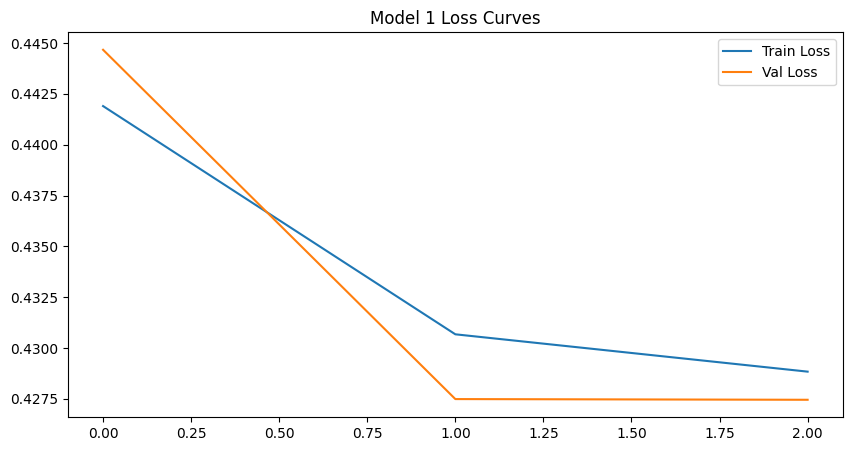

Egitim Tamamlandi.


In [ ]:
# ============================================================================
# NBCL BINARY EGITIM SCRIPT (Model 1 ve Model 2 Icin)
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# ============================================================================
# 1. AYARLAR (CONFIG)
# ============================================================================

# BURAYI DEGISTIR: Model 1 icin 1, Model 2 icin 2 yapin
TARGET_CLASS = 1

# Drive Yollari
CSV_PATH = "/content/drive/MyDrive/TUBITAK_FULL_DATASET.csv"
IMAGE_DIR = "/content/tubitak_data/images"

# Eger goruntuler zip halindeyse ve henuz cikarilmadiysa asagidaki satiri aktif et:
# !unzip -q /content/drive/MyDrive/INbreast_Processed_Images.zip -d /content/temp_images
# IMAGE_DIR = "/content/temp_images"

# Hiperparametreler
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Hedef Sinif (Target Class): {TARGET_CLASS}")
print(f"Calisma Ortami: {DEVICE}")

# ============================================================================
# 2. VERI HAZIRLIGI (NBCL Dataset)
# ============================================================================

class NBCLDataset(Dataset):
    def __init__(self, dataframe, image_dir, target_class, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.target_class = target_class

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Goruntu yukleme
        img_name = self.df.loc[idx, 'filename']
        img_path = os.path.join(self.image_dir, img_name)

        # Grayscale (L) olarak ac
        try:
            image = Image.open(img_path).convert('L')
        except Exception as e:
            # Hata durumunda siyah goruntu don (egitimi kirmamak icin)
            print(f"Hata: {img_path} bulunamadi.")
            image = Image.new('L', (224, 224), (0))

        if self.transform:
            image = self.transform(image)

        # Etiketleme Mantigi (One-vs-Rest)
        original_birads = self.df.loc[idx, 'BIRADS']

        # Eger veri hedef sinifa aitse 1.0, degilse 0.0
        if original_birads == self.target_class:
            label = 1.0
        else:
            label = 0.0

        # Float tensor dondur (BCEWithLogitsLoss icin gerekli)
        return image, torch.tensor(label, dtype=torch.float32)

# Augmentation ve Transformlar
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    # Grayscale icin normalize
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Veri Setini Yukle ve Bol
df = pd.read_csv(CSV_PATH)
print(f"Toplam Veri Sayisi: {len(df)}")

# Stratified Split (Hedef sinif dengesini koruyarak)
# Once hedef sinif kolonunu olustur (split icin)
df['binary_target'] = (df['BIRADS'] == TARGET_CLASS).astype(int)

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['binary_target'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['binary_target'], random_state=42)

# Dataset Objeleri
train_dataset = NBCLDataset(train_df, IMAGE_DIR, target_class=TARGET_CLASS, transform=train_transform)
val_dataset = NBCLDataset(val_df, IMAGE_DIR, target_class=TARGET_CLASS, transform=val_test_transform)
test_dataset = NBCLDataset(test_df, IMAGE_DIR, target_class=TARGET_CLASS, transform=val_test_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ============================================================================
# 3. MODEL TANIMI (Binary)
# ============================================================================

class NBCLBinaryModel(nn.Module):
    def __init__(self):
        super(NBCLBinaryModel, self).__init__()
        # Pretrained ResNet18
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # 1 Kanal (Grayscale) giris icin ilk kati degistir
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Cikis katini Binary (1 cikis) yap
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        return self.backbone(x)

model = NBCLBinaryModel().to(DEVICE)

# Loss ve Optimizer (Binary icin BCEWithLogitsLoss)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ============================================================================
# 4. EGITIM DONGUSU
# ============================================================================

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images).squeeze() # [Batch]

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Binary Accuracy Hesabi (Sigmoid > 0.5)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return running_loss / len(loader), accuracy_score(all_labels, all_preds)

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return running_loss / len(loader), accuracy_score(all_labels, all_preds), f1_score(all_labels, all_preds)

# ============================================================================
# 5. EGITIMI BASLAT
# ============================================================================

best_f1 = 0.0
save_path = f"/content/drive/MyDrive/Meme_Kanseri_Projesi/checkpoints/nbcl_model{TARGET_CLASS}_resnet18_best.pth"

# Klasor yoksa olustur
os.makedirs(os.path.dirname(save_path), exist_ok=True)

history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print(f"Egitim basliyor... Model: BI-RADS {TARGET_CLASS} Detector")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1 = validate(model, val_loader, criterion)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # En iyi modeli kaydet
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), save_path)
        print(f" Model kaydedildi: {save_path}")

# Sonuc Grafigi
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title(f'Model {TARGET_CLASS} Loss Curves')
plt.legend()
plt.savefig(f"/content/drive/MyDrive/Meme_Kanseri_Projesi/results/model{TARGET_CLASS}_loss.png")
plt.show()

print("Egitim Tamamlandi.")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# --- AYARLAR ---
# Resimlerin olduğu GERÇEK klasör (Bir önceki adımda düzelttiğimiz yer)
IMAGE_DIR = "/content/tubitak_data/images"
CSV_PATH = "/content/drive/MyDrive/TUBITAK_FULL_CORRECTED.csv"
SAVE_DIR = "/content/drive/MyDrive/Meme_Kanseri_Projesi/checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 32
EPOCHS_PER_CLASS = 3  # İstediğin gibi 3 epoch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Çalışma Dizini: {IMAGE_DIR}")
print(f"Cihaz: {DEVICE}")

# --- DATASET SINIFI ---
class NBCLDataset(Dataset):
    def __init__(self, dataframe, image_dir, target_class, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.target_class = target_class

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.loc[idx, 'filename']
        img_path = os.path.join(self.image_dir, filename)

        try:
            image = Image.open(img_path).convert('L')
        except:
            image = Image.new('L', (224, 224)) # Hata olursa siyah resim

        if self.transform:
            image = self.transform(image)

        # Binary Label: Hedef Sınıf = 1, Diğerleri = 0
        original_birads = self.df.loc[idx, 'BIRADS']
        label = 1.0 if original_birads == self.target_class else 0.0

        return image, torch.tensor(label, dtype=torch.float32)

# --- MODEL ---
def get_model():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model.to(DEVICE)

# --- TRANSFORMS ---
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# --- EĞİTİM FONKSİYONLARI ---
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    preds_all, labels_all = [], []

    for imgs, lbls in tqdm(loader, desc="Training", leave=False):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs).squeeze()
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(lbls.cpu().numpy())

    return total_loss / len(loader), f1_score(labels_all, preds_all, zero_division=0)

def validate(model, loader, criterion):
    model.eval()
    preds_all, labels_all = [], []

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs = model(imgs).squeeze()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(lbls.cpu().numpy())

    return accuracy_score(labels_all, preds_all), f1_score(labels_all, preds_all, zero_division=0)

# --- OTOMATİK DÖNGÜ ---
df_full = pd.read_csv(CSV_PATH)
classes_to_train = [1, 2, 4, 5]
final_report = {}

print("\n------------------------------------------------")
print("OTOMATİK EĞİTİM BAŞLIYOR (NBCL)")
print("------------------------------------------------")

for target_cls in classes_to_train:
    print(f"\n>>> Sınıf {target_cls} Modeli Eğitiliyor... (BI-RADS {target_cls} vs Others)")

    # 1. Veri Hazırlığı
    try:
        df_full['temp_target'] = (df_full['BIRADS'] == target_cls).astype(int)

        # Çok az veri varsa stratify hatası vermesin diye kontrol
        if df_full['temp_target'].sum() < 10:
            print(f"UYARI: BI-RADS {target_cls} için veri çok az. Stratify kapatılıyor.")
            train_df, val_df = train_test_split(df_full, test_size=0.2, random_state=42)
        else:
            train_df, val_df = train_test_split(df_full, test_size=0.2, stratify=df_full['temp_target'], random_state=42)

        train_ds = NBCLDataset(train_df, IMAGE_DIR, target_cls, transform=train_tf)
        val_ds = NBCLDataset(val_df, IMAGE_DIR, target_cls, transform=val_tf)

        # num_workers=0 ÖNEMLİ (Hata almamak için)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

        # 2. Model Kurulumu
        model = get_model()
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        # 3. Eğitim Döngüsü
        best_val_f1 = 0

        for epoch in range(EPOCHS_PER_CLASS):
            loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer)
            val_acc, val_f1 = validate(model, val_loader, criterion)

            print(f"   Epoch {epoch+1}/{EPOCHS_PER_CLASS} | Loss: {loss:.4f} | Train F1: {train_f1:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

            if val_f1 >= best_val_f1:
                best_val_f1 = val_f1
                torch.save(model.state_dict(), f"{SAVE_DIR}/nbcl_model{target_cls}_best.pth")

        final_report[f"Class {target_cls}"] = best_val_f1
        print(f"    Model {target_cls} Kaydedildi. En iyi F1: {best_val_f1:.4f}")

    except Exception as e:
        print(f"    Sınıf {target_cls} eğitilirken hata oluştu: {e}")
        final_report[f"Class {target_cls}"] = "FAILED"

print("\n------------------------------------------------")
print("TÜM EĞİTİMLER TAMAMLANDI")
print("------------------------------------------------")
for cls, score in final_report.items():
    print(f"{cls}: {score}")

Çalışma Dizini: /content/tubitak_data/images
Cihaz: cuda

------------------------------------------------
OTOMATİK EĞİTİM BAŞLIYOR (NBCL)
------------------------------------------------

>>> Sınıf 1 Modeli Eğitiliyor... (BI-RADS 1 vs Others)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 1/3 | Loss: 0.4536 | Train F1: 0.9084 | Val Acc: 0.8333 | Val F1: 0.9091


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 2/3 | Loss: 0.4518 | Train F1: 0.9091 | Val Acc: 0.8333 | Val F1: 0.9091


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 3/3 | Loss: 0.4521 | Train F1: 0.9091 | Val Acc: 0.8333 | Val F1: 0.9091
    Model 1 Kaydedildi. En iyi F1: 0.9091

>>> Sınıf 2 Modeli Eğitiliyor... (BI-RADS 2 vs Others)


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 1/3 | Loss: 0.4154 | Train F1: 0.0000 | Val Acc: 0.8557 | Val F1: 0.0000


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 2/3 | Loss: 0.4139 | Train F1: 0.0000 | Val Acc: 0.8557 | Val F1: 0.0000


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 3/3 | Loss: 0.4138 | Train F1: 0.0000 | Val Acc: 0.8557 | Val F1: 0.0000
    Model 2 Kaydedildi. En iyi F1: 0.0000

>>> Sınıf 4 Modeli Eğitiliyor... (BI-RADS 4 vs Others)


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 1/3 | Loss: 0.0080 | Train F1: 0.0000 | Val Acc: 0.9996 | Val F1: 0.0000


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 2/3 | Loss: 0.0035 | Train F1: 0.0000 | Val Acc: 0.9996 | Val F1: 0.0000


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm

# --- AYARLAR ---
IMAGE_DIR = "/content/tubitak_data/images"
CSV_PATH = "/content/drive/MyDrive/TUBITAK_FULL_CORRECTED.csv"
SAVE_DIR = "/content/drive/MyDrive/Meme_Kanseri_Projesi/checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 32
EPOCHS_PER_CLASS = 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- DATASET ---
class NBCLDataset(Dataset):
    def __init__(self, dataframe, image_dir, target_class, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.target_class = target_class

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.loc[idx, 'filename']
        img_path = os.path.join(self.image_dir, filename)

        try:
            image = Image.open(img_path).convert('L')
        except:
            image = Image.new('L', (224, 224))

        if self.transform:
            image = self.transform(image)

        original_birads = self.df.loc[idx, 'BIRADS']
        label = 1.0 if original_birads == self.target_class else 0.0
        return image, torch.tensor(label, dtype=torch.float32)

# --- MODEL ---
def get_model():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model.to(DEVICE)

# --- TRANSFORMS ---
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# --- EĞİTİM LOOP ---
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    preds_all, labels_all = [], []
    total_loss = 0

    for imgs, lbls in tqdm(loader, desc="Training", leave=False):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs).squeeze()

        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(lbls.cpu().numpy())

    return total_loss/len(loader), f1_score(labels_all, preds_all, zero_division=0)

def validate(model, loader):
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs = model(imgs).squeeze()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(lbls.cpu().numpy())
    return accuracy_score(labels_all, preds_all), f1_score(labels_all, preds_all, zero_division=0)

# --- ANA KOD (WEIGHTED LOSS EKLENDİ) ---
df_full = pd.read_csv(CSV_PATH)
classes_to_train = [1, 2, 4, 5]

print("AĞIRLIKLI EĞİTİM BAŞLIYOR (Weighted Loss ile)")

for target_cls in classes_to_train:
    print(f"\n>>> Sınıf {target_cls} Modeli (BI-RADS {target_cls})")

    # 1. Dataset Hazırlığı
    df_full['temp_target'] = (df_full['BIRADS'] == target_cls).astype(int)

    # AĞIRLIK HESAPLAMA (KRİTİK ADIM)
    num_pos = df_full['temp_target'].sum()
    num_neg = len(df_full) - num_pos
    if num_pos == 0: continue # Veri yoksa geç

    # Pozitif örneklere ne kadar çok önem vereceğiz?
    # Negatif / Pozitif oranı kadar ağırlık veriyoruz.
    pos_weight = torch.tensor([num_neg / num_pos]).to(DEVICE)
    print(f"   Veri Dağılımı -> Pozitif: {num_pos}, Negatif: {num_neg}")
    print(f"   Uygulanan Ağırlık (pos_weight): {pos_weight.item():.2f}")

    if num_pos < 50:
        # Çok az veri varsa rastgele böl
        train_df, val_df = train_test_split(df_full, test_size=0.2, random_state=42)
    else:
        # Yeterli veri varsa dengeli böl
        train_df, val_df = train_test_split(df_full, test_size=0.2, stratify=df_full['temp_target'], random_state=42)

    train_ds = NBCLDataset(train_df, IMAGE_DIR, target_cls, transform=train_tf)
    val_ds = NBCLDataset(val_df, IMAGE_DIR, target_cls, transform=val_tf)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # 2. Model ve Loss (Ağırlıklı)
    model = get_model()
    # Loss fonksiyonuna ağırlığı veriyoruz!
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    best_f1 = 0.0
    for epoch in range(EPOCHS_PER_CLASS):
        loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer)
        val_acc, val_f1 = validate(model, val_loader)

        print(f"   Epoch {epoch+1} | Loss: {loss:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

        if val_f1 >= best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"{SAVE_DIR}/nbcl_model{target_cls}_weighted_best.pth")

    print(f" Sınıf {target_cls} tamamlandı. En iyi F1: {best_f1:.4f}")

AĞIRLIKLI EĞİTİM BAŞLIYOR (Weighted Loss ile)

>>> Sınıf 1 Modeli (BI-RADS 1)
   Veri Dağılımı -> Pozitif: 45910, Negatif: 9184
   Uygulanan Ağırlık (pos_weight): 0.20


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 1 | Loss: 0.2324 | Train F1: 0.6202 | Val F1: 0.0000


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 2 | Loss: 0.2318 | Train F1: 0.6340 | Val F1: 0.0000


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 3 | Loss: 0.2319 | Train F1: 0.6381 | Val F1: 0.0000
 Sınıf 1 tamamlandı. En iyi F1: 0.0000

>>> Sınıf 2 Modeli (BI-RADS 2)
   Veri Dağılımı -> Pozitif: 7948, Negatif: 47146
   Uygulanan Ağırlık (pos_weight): 5.93


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 1 | Loss: 1.1932 | Train F1: 0.2229 | Val F1: 0.0000


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 2 | Loss: 1.1895 | Train F1: 0.2274 | Val F1: 0.2522


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 3 | Loss: 1.1920 | Train F1: 0.2229 | Val F1: 0.0000
 Sınıf 2 tamamlandı. En iyi F1: 0.2522

>>> Sınıf 4 Modeli (BI-RADS 4)
   Veri Dağılımı -> Pozitif: 21, Negatif: 55073
   Uygulanan Ağırlık (pos_weight): 2622.52


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 1 | Loss: 2.1207 | Train F1: 0.0007 | Val F1: 0.0004


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 2 | Loss: 1.6095 | Train F1: 0.0008 | Val F1: 0.0000


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 3 | Loss: 1.6153 | Train F1: 0.0010 | Val F1: 0.0000
 Sınıf 4 tamamlandı. En iyi F1: 0.0004

>>> Sınıf 5 Modeli (BI-RADS 5)
   Veri Dağılımı -> Pozitif: 1215, Negatif: 53879
   Uygulanan Ağırlık (pos_weight): 44.34


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 1 | Loss: 1.3719 | Train F1: 0.0424 | Val F1: 0.0432


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 2 | Loss: 1.3650 | Train F1: 0.0428 | Val F1: 0.0000


Training:   0%|          | 0/1378 [00:00<?, ?it/s]

   Epoch 3 | Loss: 1.3708 | Train F1: 0.0418 | Val F1: 0.0000
 Sınıf 5 tamamlandı. En iyi F1: 0.0432
